# light gbm-cv 데모
* cross-validation
검증 방법: hold out validation, n-fold cv, stratified n-fold cv,leave one out
## 라이브러리 import 및 설정

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [25]:
data_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')
sub_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\sub\\')
feature_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')

val_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\val')
tst_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\tst')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 3054

In [26]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
#df.head()

(400000, 20)


In [27]:
y = df[target_col].values[:320000]         #종속
df.drop(target_col, axis=1, inplace=True)  #독립을 위한 종속 제거
trn = df.iloc[:320000].values                  #train을 위한 독립 320000개     
tst = df.iloc[320000:].values              #test을 위한 독립 80000개
feature_name = df.columns.tolist()         #독립변수 이름 리스트로 변환
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.  
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [28]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습


In [30]:
#3000 256 0.009 1000 1 1 0.8 seed -1
#93.3453%
#3000 256 0.009 2000 1 1 0.8 seed -1
#93.4022%
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
#(cv.split(),1)
# -  StratifiedKFold 경우, trn,y 독립과 종속(동일 분포를 위해) 인자
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             #종속 타입에 따라 변경 가능 
                             n_estimators=3000,
                             num_leaves=256,
                             learning_rate=0.009,
                             subsample=.8,
                             subsample_freq=1,
                             num_iteration=2000,
                             colsample_bytree=.6,
                             random_state=seed,
                             n_jobs=-1)
    
    clf.fit(trn[i_trn], y[i_trn],  eval_set=[(trn[i_val], y[i_val])], eval_metric='multiclass',  early_stopping_rounds=15)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    #확률로 예측값 출력
    p_tst += clf.predict_proba(tst) / n_fold
    #평균 효과를 위해 먼저 폴드 개수만큼 나누어 초기화

training model for CV #1
[1]	valid_0's multi_logloss: 0.973749
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 0.96141
[3]	valid_0's multi_logloss: 0.950023
[4]	valid_0's multi_logloss: 0.938993
[5]	valid_0's multi_logloss: 0.927976
[6]	valid_0's multi_logloss: 0.916474
[7]	valid_0's multi_logloss: 0.906564
[8]	valid_0's multi_logloss: 0.896833
[9]	valid_0's multi_logloss: 0.886647
[10]	valid_0's multi_logloss: 0.876922
[11]	valid_0's multi_logloss: 0.867046
[12]	valid_0's multi_logloss: 0.857335
[13]	valid_0's multi_logloss: 0.847052
[14]	valid_0's multi_logloss: 0.83868
[15]	valid_0's multi_logloss: 0.830397
[16]	valid_0's multi_logloss: 0.821475
[17]	valid_0's multi_logloss: 0.812577
[18]	valid_0's multi_logloss: 0.803255
[19]	valid_0's multi_logloss: 0.794507
[20]	valid_0's multi_logloss: 0.786588
[21]	valid_0's multi_logloss: 0.777571
[22]	valid_0's multi_logloss: 0.769996
[23]	valid_0's multi_logloss: 0.7631
[24]	valid_0's multi_logloss: 

[207]	valid_0's multi_logloss: 0.252037
[208]	valid_0's multi_logloss: 0.251142
[209]	valid_0's multi_logloss: 0.250358
[210]	valid_0's multi_logloss: 0.249702
[211]	valid_0's multi_logloss: 0.249129
[212]	valid_0's multi_logloss: 0.248495
[213]	valid_0's multi_logloss: 0.247798
[214]	valid_0's multi_logloss: 0.246958
[215]	valid_0's multi_logloss: 0.246316
[216]	valid_0's multi_logloss: 0.245498
[217]	valid_0's multi_logloss: 0.244921
[218]	valid_0's multi_logloss: 0.244103
[219]	valid_0's multi_logloss: 0.243291
[220]	valid_0's multi_logloss: 0.242506
[221]	valid_0's multi_logloss: 0.241651
[222]	valid_0's multi_logloss: 0.240951
[223]	valid_0's multi_logloss: 0.240192
[224]	valid_0's multi_logloss: 0.239461
[225]	valid_0's multi_logloss: 0.238766
[226]	valid_0's multi_logloss: 0.238159
[227]	valid_0's multi_logloss: 0.237386
[228]	valid_0's multi_logloss: 0.236693
[229]	valid_0's multi_logloss: 0.236108
[230]	valid_0's multi_logloss: 0.235416
[231]	valid_0's multi_logloss: 0.234904


[413]	valid_0's multi_logloss: 0.177737
[414]	valid_0's multi_logloss: 0.177596
[415]	valid_0's multi_logloss: 0.177437
[416]	valid_0's multi_logloss: 0.17729
[417]	valid_0's multi_logloss: 0.177123
[418]	valid_0's multi_logloss: 0.177019
[419]	valid_0's multi_logloss: 0.176942
[420]	valid_0's multi_logloss: 0.17682
[421]	valid_0's multi_logloss: 0.176701
[422]	valid_0's multi_logloss: 0.176613
[423]	valid_0's multi_logloss: 0.176457
[424]	valid_0's multi_logloss: 0.176311
[425]	valid_0's multi_logloss: 0.176187
[426]	valid_0's multi_logloss: 0.176114
[427]	valid_0's multi_logloss: 0.176009
[428]	valid_0's multi_logloss: 0.175882
[429]	valid_0's multi_logloss: 0.175739
[430]	valid_0's multi_logloss: 0.175592
[431]	valid_0's multi_logloss: 0.175472
[432]	valid_0's multi_logloss: 0.175387
[433]	valid_0's multi_logloss: 0.175256
[434]	valid_0's multi_logloss: 0.175155
[435]	valid_0's multi_logloss: 0.17508
[436]	valid_0's multi_logloss: 0.17495
[437]	valid_0's multi_logloss: 0.174896
[438

[824]	valid_0's multi_logloss: 0.159016
[825]	valid_0's multi_logloss: 0.159004
[826]	valid_0's multi_logloss: 0.158989
[827]	valid_0's multi_logloss: 0.158975
[828]	valid_0's multi_logloss: 0.158962
[829]	valid_0's multi_logloss: 0.158949
[830]	valid_0's multi_logloss: 0.158932
[831]	valid_0's multi_logloss: 0.158924
[832]	valid_0's multi_logloss: 0.158909
[833]	valid_0's multi_logloss: 0.158897
[834]	valid_0's multi_logloss: 0.158886
[835]	valid_0's multi_logloss: 0.158877
[836]	valid_0's multi_logloss: 0.158863
[837]	valid_0's multi_logloss: 0.158856
[838]	valid_0's multi_logloss: 0.158847
[839]	valid_0's multi_logloss: 0.158838
[840]	valid_0's multi_logloss: 0.158829
[841]	valid_0's multi_logloss: 0.15882
[842]	valid_0's multi_logloss: 0.158812
[843]	valid_0's multi_logloss: 0.158806
[844]	valid_0's multi_logloss: 0.158793
[845]	valid_0's multi_logloss: 0.158788
[846]	valid_0's multi_logloss: 0.158783
[847]	valid_0's multi_logloss: 0.158771
[848]	valid_0's multi_logloss: 0.158767
[

[1029]	valid_0's multi_logloss: 0.157878
[1030]	valid_0's multi_logloss: 0.157875
[1031]	valid_0's multi_logloss: 0.157873
[1032]	valid_0's multi_logloss: 0.157872
[1033]	valid_0's multi_logloss: 0.157867
[1034]	valid_0's multi_logloss: 0.157868
[1035]	valid_0's multi_logloss: 0.157862
[1036]	valid_0's multi_logloss: 0.157861
[1037]	valid_0's multi_logloss: 0.157858
[1038]	valid_0's multi_logloss: 0.157851
[1039]	valid_0's multi_logloss: 0.157854
[1040]	valid_0's multi_logloss: 0.157849
[1041]	valid_0's multi_logloss: 0.157846
[1042]	valid_0's multi_logloss: 0.15784
[1043]	valid_0's multi_logloss: 0.157841
[1044]	valid_0's multi_logloss: 0.15784
[1045]	valid_0's multi_logloss: 0.157842
[1046]	valid_0's multi_logloss: 0.157846
[1047]	valid_0's multi_logloss: 0.157847
[1048]	valid_0's multi_logloss: 0.157846
[1049]	valid_0's multi_logloss: 0.157843
[1050]	valid_0's multi_logloss: 0.157839
[1051]	valid_0's multi_logloss: 0.157839
[1052]	valid_0's multi_logloss: 0.157834
[1053]	valid_0's m

[27]	valid_0's multi_logloss: 0.733376
[28]	valid_0's multi_logloss: 0.726923
[29]	valid_0's multi_logloss: 0.719082
[30]	valid_0's multi_logloss: 0.71229
[31]	valid_0's multi_logloss: 0.704733
[32]	valid_0's multi_logloss: 0.69809
[33]	valid_0's multi_logloss: 0.691658
[34]	valid_0's multi_logloss: 0.684846
[35]	valid_0's multi_logloss: 0.678289
[36]	valid_0's multi_logloss: 0.671964
[37]	valid_0's multi_logloss: 0.665376
[38]	valid_0's multi_logloss: 0.659198
[39]	valid_0's multi_logloss: 0.653249
[40]	valid_0's multi_logloss: 0.647299
[41]	valid_0's multi_logloss: 0.640984
[42]	valid_0's multi_logloss: 0.636271
[43]	valid_0's multi_logloss: 0.630677
[44]	valid_0's multi_logloss: 0.624666
[45]	valid_0's multi_logloss: 0.619515
[46]	valid_0's multi_logloss: 0.614079
[47]	valid_0's multi_logloss: 0.608728
[48]	valid_0's multi_logloss: 0.603153
[49]	valid_0's multi_logloss: 0.59805
[50]	valid_0's multi_logloss: 0.592667
[51]	valid_0's multi_logloss: 0.587735
[52]	valid_0's multi_logloss

[235]	valid_0's multi_logloss: 0.234753
[236]	valid_0's multi_logloss: 0.234167
[237]	valid_0's multi_logloss: 0.233719
[238]	valid_0's multi_logloss: 0.23308
[239]	valid_0's multi_logloss: 0.232616
[240]	valid_0's multi_logloss: 0.232093
[241]	valid_0's multi_logloss: 0.231625
[242]	valid_0's multi_logloss: 0.231035
[243]	valid_0's multi_logloss: 0.230614
[244]	valid_0's multi_logloss: 0.230219
[245]	valid_0's multi_logloss: 0.22959
[246]	valid_0's multi_logloss: 0.2292
[247]	valid_0's multi_logloss: 0.228678
[248]	valid_0's multi_logloss: 0.227983
[249]	valid_0's multi_logloss: 0.227403
[250]	valid_0's multi_logloss: 0.226897
[251]	valid_0's multi_logloss: 0.226497
[252]	valid_0's multi_logloss: 0.225832
[253]	valid_0's multi_logloss: 0.225347
[254]	valid_0's multi_logloss: 0.224907
[255]	valid_0's multi_logloss: 0.224376
[256]	valid_0's multi_logloss: 0.223961
[257]	valid_0's multi_logloss: 0.223411
[258]	valid_0's multi_logloss: 0.223012
[259]	valid_0's multi_logloss: 0.222452
[260

[441]	valid_0's multi_logloss: 0.176128
[442]	valid_0's multi_logloss: 0.176005
[443]	valid_0's multi_logloss: 0.175906
[444]	valid_0's multi_logloss: 0.175752
[445]	valid_0's multi_logloss: 0.175637
[446]	valid_0's multi_logloss: 0.175568
[447]	valid_0's multi_logloss: 0.175498
[448]	valid_0's multi_logloss: 0.175404
[449]	valid_0's multi_logloss: 0.175294
[450]	valid_0's multi_logloss: 0.175214
[451]	valid_0's multi_logloss: 0.175146
[452]	valid_0's multi_logloss: 0.175051
[453]	valid_0's multi_logloss: 0.17493
[454]	valid_0's multi_logloss: 0.174844
[455]	valid_0's multi_logloss: 0.174771
[456]	valid_0's multi_logloss: 0.174702
[457]	valid_0's multi_logloss: 0.174595
[458]	valid_0's multi_logloss: 0.174531
[459]	valid_0's multi_logloss: 0.174411
[460]	valid_0's multi_logloss: 0.174287
[461]	valid_0's multi_logloss: 0.174171
[462]	valid_0's multi_logloss: 0.174078
[463]	valid_0's multi_logloss: 0.173996
[464]	valid_0's multi_logloss: 0.173876
[465]	valid_0's multi_logloss: 0.173763
[

[647]	valid_0's multi_logloss: 0.16356
[648]	valid_0's multi_logloss: 0.163536
[649]	valid_0's multi_logloss: 0.163508
[650]	valid_0's multi_logloss: 0.163472
[651]	valid_0's multi_logloss: 0.16345
[652]	valid_0's multi_logloss: 0.163417
[653]	valid_0's multi_logloss: 0.163388
[654]	valid_0's multi_logloss: 0.163353
[655]	valid_0's multi_logloss: 0.163312
[656]	valid_0's multi_logloss: 0.163296
[657]	valid_0's multi_logloss: 0.163266
[658]	valid_0's multi_logloss: 0.163239
[659]	valid_0's multi_logloss: 0.163211
[660]	valid_0's multi_logloss: 0.163173
[661]	valid_0's multi_logloss: 0.163152
[662]	valid_0's multi_logloss: 0.163124
[663]	valid_0's multi_logloss: 0.163088
[664]	valid_0's multi_logloss: 0.163055
[665]	valid_0's multi_logloss: 0.16303
[666]	valid_0's multi_logloss: 0.163003
[667]	valid_0's multi_logloss: 0.162971
[668]	valid_0's multi_logloss: 0.162945
[669]	valid_0's multi_logloss: 0.162906
[670]	valid_0's multi_logloss: 0.162868
[671]	valid_0's multi_logloss: 0.162852
[67

[853]	valid_0's multi_logloss: 0.159758
[854]	valid_0's multi_logloss: 0.159745
[855]	valid_0's multi_logloss: 0.159734
[856]	valid_0's multi_logloss: 0.159728
[857]	valid_0's multi_logloss: 0.159722
[858]	valid_0's multi_logloss: 0.159714
[859]	valid_0's multi_logloss: 0.159704
[860]	valid_0's multi_logloss: 0.159698
[861]	valid_0's multi_logloss: 0.159691
[862]	valid_0's multi_logloss: 0.159682
[863]	valid_0's multi_logloss: 0.159672
[864]	valid_0's multi_logloss: 0.159663
[865]	valid_0's multi_logloss: 0.159649
[866]	valid_0's multi_logloss: 0.159639
[867]	valid_0's multi_logloss: 0.159627
[868]	valid_0's multi_logloss: 0.159618
[869]	valid_0's multi_logloss: 0.159615
[870]	valid_0's multi_logloss: 0.159613
[871]	valid_0's multi_logloss: 0.159604
[872]	valid_0's multi_logloss: 0.159597
[873]	valid_0's multi_logloss: 0.159592
[874]	valid_0's multi_logloss: 0.159578
[875]	valid_0's multi_logloss: 0.15957
[876]	valid_0's multi_logloss: 0.159559
[877]	valid_0's multi_logloss: 0.159548
[

[1057]	valid_0's multi_logloss: 0.158566
[1058]	valid_0's multi_logloss: 0.158566
[1059]	valid_0's multi_logloss: 0.158565
[1060]	valid_0's multi_logloss: 0.15856
[1061]	valid_0's multi_logloss: 0.158556
[1062]	valid_0's multi_logloss: 0.158554
[1063]	valid_0's multi_logloss: 0.158551
[1064]	valid_0's multi_logloss: 0.15855
[1065]	valid_0's multi_logloss: 0.158544
[1066]	valid_0's multi_logloss: 0.158538
[1067]	valid_0's multi_logloss: 0.158539
[1068]	valid_0's multi_logloss: 0.158531
[1069]	valid_0's multi_logloss: 0.158528
[1070]	valid_0's multi_logloss: 0.158527
[1071]	valid_0's multi_logloss: 0.158522
[1072]	valid_0's multi_logloss: 0.158519
[1073]	valid_0's multi_logloss: 0.158519
[1074]	valid_0's multi_logloss: 0.158514
[1075]	valid_0's multi_logloss: 0.158511
[1076]	valid_0's multi_logloss: 0.158507
[1077]	valid_0's multi_logloss: 0.158505
[1078]	valid_0's multi_logloss: 0.1585
[1079]	valid_0's multi_logloss: 0.158499
[1080]	valid_0's multi_logloss: 0.158497
[1081]	valid_0's mul

[1258]	valid_0's multi_logloss: 0.15818
[1259]	valid_0's multi_logloss: 0.158184
[1260]	valid_0's multi_logloss: 0.158184
[1261]	valid_0's multi_logloss: 0.158185
[1262]	valid_0's multi_logloss: 0.158184
[1263]	valid_0's multi_logloss: 0.15818
[1264]	valid_0's multi_logloss: 0.158177
[1265]	valid_0's multi_logloss: 0.158176
[1266]	valid_0's multi_logloss: 0.158175
[1267]	valid_0's multi_logloss: 0.158178
[1268]	valid_0's multi_logloss: 0.158179
[1269]	valid_0's multi_logloss: 0.158179
[1270]	valid_0's multi_logloss: 0.158177
[1271]	valid_0's multi_logloss: 0.158175
[1272]	valid_0's multi_logloss: 0.158174
[1273]	valid_0's multi_logloss: 0.158171
[1274]	valid_0's multi_logloss: 0.158172
[1275]	valid_0's multi_logloss: 0.158173
[1276]	valid_0's multi_logloss: 0.158173
[1277]	valid_0's multi_logloss: 0.158174
[1278]	valid_0's multi_logloss: 0.158175
[1279]	valid_0's multi_logloss: 0.15817
[1280]	valid_0's multi_logloss: 0.158173
[1281]	valid_0's multi_logloss: 0.158167
[1282]	valid_0's mu

[150]	valid_0's multi_logloss: 0.315805
[151]	valid_0's multi_logloss: 0.314644
[152]	valid_0's multi_logloss: 0.313347
[153]	valid_0's multi_logloss: 0.312253
[154]	valid_0's multi_logloss: 0.31084
[155]	valid_0's multi_logloss: 0.309226
[156]	valid_0's multi_logloss: 0.308261
[157]	valid_0's multi_logloss: 0.306984
[158]	valid_0's multi_logloss: 0.305675
[159]	valid_0's multi_logloss: 0.304259
[160]	valid_0's multi_logloss: 0.302772
[161]	valid_0's multi_logloss: 0.301456
[162]	valid_0's multi_logloss: 0.300178
[163]	valid_0's multi_logloss: 0.298971
[164]	valid_0's multi_logloss: 0.297753
[165]	valid_0's multi_logloss: 0.296499
[166]	valid_0's multi_logloss: 0.295078
[167]	valid_0's multi_logloss: 0.294271
[168]	valid_0's multi_logloss: 0.293019
[169]	valid_0's multi_logloss: 0.291788
[170]	valid_0's multi_logloss: 0.290785
[171]	valid_0's multi_logloss: 0.289816
[172]	valid_0's multi_logloss: 0.288587
[173]	valid_0's multi_logloss: 0.287629
[174]	valid_0's multi_logloss: 0.286387
[

[356]	valid_0's multi_logloss: 0.190146
[357]	valid_0's multi_logloss: 0.189989
[358]	valid_0's multi_logloss: 0.189773
[359]	valid_0's multi_logloss: 0.189511
[360]	valid_0's multi_logloss: 0.189338
[361]	valid_0's multi_logloss: 0.189126
[362]	valid_0's multi_logloss: 0.18895
[363]	valid_0's multi_logloss: 0.188816
[364]	valid_0's multi_logloss: 0.188632
[365]	valid_0's multi_logloss: 0.188428
[366]	valid_0's multi_logloss: 0.188179
[367]	valid_0's multi_logloss: 0.188032
[368]	valid_0's multi_logloss: 0.187857
[369]	valid_0's multi_logloss: 0.187633
[370]	valid_0's multi_logloss: 0.187411
[371]	valid_0's multi_logloss: 0.187184
[372]	valid_0's multi_logloss: 0.187053
[373]	valid_0's multi_logloss: 0.186816
[374]	valid_0's multi_logloss: 0.186675
[375]	valid_0's multi_logloss: 0.186452
[376]	valid_0's multi_logloss: 0.186232
[377]	valid_0's multi_logloss: 0.18606
[378]	valid_0's multi_logloss: 0.185848
[379]	valid_0's multi_logloss: 0.185624
[380]	valid_0's multi_logloss: 0.185431
[3

[563]	valid_0's multi_logloss: 0.167556
[564]	valid_0's multi_logloss: 0.167478
[565]	valid_0's multi_logloss: 0.167444
[566]	valid_0's multi_logloss: 0.1674
[567]	valid_0's multi_logloss: 0.167351
[568]	valid_0's multi_logloss: 0.167319
[569]	valid_0's multi_logloss: 0.167267
[570]	valid_0's multi_logloss: 0.167206
[571]	valid_0's multi_logloss: 0.167152
[572]	valid_0's multi_logloss: 0.167112
[573]	valid_0's multi_logloss: 0.167066
[574]	valid_0's multi_logloss: 0.167023
[575]	valid_0's multi_logloss: 0.166976
[576]	valid_0's multi_logloss: 0.166914
[577]	valid_0's multi_logloss: 0.166864
[578]	valid_0's multi_logloss: 0.16681
[579]	valid_0's multi_logloss: 0.16675
[580]	valid_0's multi_logloss: 0.166719
[581]	valid_0's multi_logloss: 0.166669
[582]	valid_0's multi_logloss: 0.166628
[583]	valid_0's multi_logloss: 0.166575
[584]	valid_0's multi_logloss: 0.166536
[585]	valid_0's multi_logloss: 0.166503
[586]	valid_0's multi_logloss: 0.166457
[587]	valid_0's multi_logloss: 0.166404
[588

[769]	valid_0's multi_logloss: 0.161537
[770]	valid_0's multi_logloss: 0.161526
[771]	valid_0's multi_logloss: 0.161518
[772]	valid_0's multi_logloss: 0.161504
[773]	valid_0's multi_logloss: 0.161496
[774]	valid_0's multi_logloss: 0.161476
[775]	valid_0's multi_logloss: 0.161454
[776]	valid_0's multi_logloss: 0.161446
[777]	valid_0's multi_logloss: 0.161429
[778]	valid_0's multi_logloss: 0.161413
[779]	valid_0's multi_logloss: 0.161402
[780]	valid_0's multi_logloss: 0.161381
[781]	valid_0's multi_logloss: 0.161362
[782]	valid_0's multi_logloss: 0.161347
[783]	valid_0's multi_logloss: 0.161338
[784]	valid_0's multi_logloss: 0.161322
[785]	valid_0's multi_logloss: 0.161312
[786]	valid_0's multi_logloss: 0.161299
[787]	valid_0's multi_logloss: 0.161284
[788]	valid_0's multi_logloss: 0.161266
[789]	valid_0's multi_logloss: 0.161256
[790]	valid_0's multi_logloss: 0.161245
[791]	valid_0's multi_logloss: 0.161239
[792]	valid_0's multi_logloss: 0.161222
[793]	valid_0's multi_logloss: 0.161209


[977]	valid_0's multi_logloss: 0.159726
[978]	valid_0's multi_logloss: 0.159725
[979]	valid_0's multi_logloss: 0.15972
[980]	valid_0's multi_logloss: 0.159715
[981]	valid_0's multi_logloss: 0.15971
[982]	valid_0's multi_logloss: 0.159706
[983]	valid_0's multi_logloss: 0.1597
[984]	valid_0's multi_logloss: 0.159697
[985]	valid_0's multi_logloss: 0.159693
[986]	valid_0's multi_logloss: 0.159688
[987]	valid_0's multi_logloss: 0.159685
[988]	valid_0's multi_logloss: 0.159679
[989]	valid_0's multi_logloss: 0.159673
[990]	valid_0's multi_logloss: 0.159664
[991]	valid_0's multi_logloss: 0.159661
[992]	valid_0's multi_logloss: 0.15966
[993]	valid_0's multi_logloss: 0.159658
[994]	valid_0's multi_logloss: 0.159656
[995]	valid_0's multi_logloss: 0.159647
[996]	valid_0's multi_logloss: 0.159638
[997]	valid_0's multi_logloss: 0.159634
[998]	valid_0's multi_logloss: 0.15963
[999]	valid_0's multi_logloss: 0.159622
[1000]	valid_0's multi_logloss: 0.159615
[1001]	valid_0's multi_logloss: 0.159615
[100

[1178]	valid_0's multi_logloss: 0.159186
[1179]	valid_0's multi_logloss: 0.159181
[1180]	valid_0's multi_logloss: 0.159182
[1181]	valid_0's multi_logloss: 0.159181
[1182]	valid_0's multi_logloss: 0.159184
[1183]	valid_0's multi_logloss: 0.159185
[1184]	valid_0's multi_logloss: 0.159183
[1185]	valid_0's multi_logloss: 0.159186
[1186]	valid_0's multi_logloss: 0.159184
[1187]	valid_0's multi_logloss: 0.15918
[1188]	valid_0's multi_logloss: 0.159174
[1189]	valid_0's multi_logloss: 0.159175
[1190]	valid_0's multi_logloss: 0.159171
[1191]	valid_0's multi_logloss: 0.159173
[1192]	valid_0's multi_logloss: 0.159171
[1193]	valid_0's multi_logloss: 0.159171
[1194]	valid_0's multi_logloss: 0.159174
[1195]	valid_0's multi_logloss: 0.159169
[1196]	valid_0's multi_logloss: 0.159172
[1197]	valid_0's multi_logloss: 0.15917
[1198]	valid_0's multi_logloss: 0.159168
[1199]	valid_0's multi_logloss: 0.15917
[1200]	valid_0's multi_logloss: 0.159166
[1201]	valid_0's multi_logloss: 0.159165
[1202]	valid_0's mu

[105]	valid_0's multi_logloss: 0.401521
[106]	valid_0's multi_logloss: 0.399357
[107]	valid_0's multi_logloss: 0.397057
[108]	valid_0's multi_logloss: 0.39476
[109]	valid_0's multi_logloss: 0.392529
[110]	valid_0's multi_logloss: 0.39016
[111]	valid_0's multi_logloss: 0.387826
[112]	valid_0's multi_logloss: 0.385841
[113]	valid_0's multi_logloss: 0.383596
[114]	valid_0's multi_logloss: 0.381367
[115]	valid_0's multi_logloss: 0.379136
[116]	valid_0's multi_logloss: 0.377287
[117]	valid_0's multi_logloss: 0.375148
[118]	valid_0's multi_logloss: 0.372833
[119]	valid_0's multi_logloss: 0.370474
[120]	valid_0's multi_logloss: 0.368822
[121]	valid_0's multi_logloss: 0.366562
[122]	valid_0's multi_logloss: 0.36421
[123]	valid_0's multi_logloss: 0.362202
[124]	valid_0's multi_logloss: 0.360665
[125]	valid_0's multi_logloss: 0.358628
[126]	valid_0's multi_logloss: 0.356489
[127]	valid_0's multi_logloss: 0.354293
[128]	valid_0's multi_logloss: 0.35221
[129]	valid_0's multi_logloss: 0.350206
[130

[312]	valid_0's multi_logloss: 0.201618
[313]	valid_0's multi_logloss: 0.201337
[314]	valid_0's multi_logloss: 0.201135
[315]	valid_0's multi_logloss: 0.200802
[316]	valid_0's multi_logloss: 0.200418
[317]	valid_0's multi_logloss: 0.200187
[318]	valid_0's multi_logloss: 0.199855
[319]	valid_0's multi_logloss: 0.199545
[320]	valid_0's multi_logloss: 0.199218
[321]	valid_0's multi_logloss: 0.198885
[322]	valid_0's multi_logloss: 0.198573
[323]	valid_0's multi_logloss: 0.198405
[324]	valid_0's multi_logloss: 0.198129
[325]	valid_0's multi_logloss: 0.197843
[326]	valid_0's multi_logloss: 0.197595
[327]	valid_0's multi_logloss: 0.19728
[328]	valid_0's multi_logloss: 0.196946
[329]	valid_0's multi_logloss: 0.196634
[330]	valid_0's multi_logloss: 0.196476
[331]	valid_0's multi_logloss: 0.196133
[332]	valid_0's multi_logloss: 0.195859
[333]	valid_0's multi_logloss: 0.195577
[334]	valid_0's multi_logloss: 0.195277
[335]	valid_0's multi_logloss: 0.194959
[336]	valid_0's multi_logloss: 0.194758
[

[519]	valid_0's multi_logloss: 0.169864
[520]	valid_0's multi_logloss: 0.169821
[521]	valid_0's multi_logloss: 0.169756
[522]	valid_0's multi_logloss: 0.169687
[523]	valid_0's multi_logloss: 0.169635
[524]	valid_0's multi_logloss: 0.169572
[525]	valid_0's multi_logloss: 0.169537
[526]	valid_0's multi_logloss: 0.169498
[527]	valid_0's multi_logloss: 0.169424
[528]	valid_0's multi_logloss: 0.169382
[529]	valid_0's multi_logloss: 0.1693
[530]	valid_0's multi_logloss: 0.169261
[531]	valid_0's multi_logloss: 0.169215
[532]	valid_0's multi_logloss: 0.169165
[533]	valid_0's multi_logloss: 0.169108
[534]	valid_0's multi_logloss: 0.16907
[535]	valid_0's multi_logloss: 0.168996
[536]	valid_0's multi_logloss: 0.16894
[537]	valid_0's multi_logloss: 0.168857
[538]	valid_0's multi_logloss: 0.168807
[539]	valid_0's multi_logloss: 0.168741
[540]	valid_0's multi_logloss: 0.168683
[541]	valid_0's multi_logloss: 0.168607
[542]	valid_0's multi_logloss: 0.168554
[543]	valid_0's multi_logloss: 0.168486
[544

[726]	valid_0's multi_logloss: 0.162157
[727]	valid_0's multi_logloss: 0.162143
[728]	valid_0's multi_logloss: 0.162117
[729]	valid_0's multi_logloss: 0.1621
[730]	valid_0's multi_logloss: 0.162084
[731]	valid_0's multi_logloss: 0.162065
[732]	valid_0's multi_logloss: 0.162044
[733]	valid_0's multi_logloss: 0.162026
[734]	valid_0's multi_logloss: 0.162003
[735]	valid_0's multi_logloss: 0.161992
[736]	valid_0's multi_logloss: 0.16197
[737]	valid_0's multi_logloss: 0.161955
[738]	valid_0's multi_logloss: 0.161939
[739]	valid_0's multi_logloss: 0.161929
[740]	valid_0's multi_logloss: 0.161908
[741]	valid_0's multi_logloss: 0.161881
[742]	valid_0's multi_logloss: 0.161859
[743]	valid_0's multi_logloss: 0.161845
[744]	valid_0's multi_logloss: 0.161825
[745]	valid_0's multi_logloss: 0.161802
[746]	valid_0's multi_logloss: 0.161781
[747]	valid_0's multi_logloss: 0.161762
[748]	valid_0's multi_logloss: 0.161741
[749]	valid_0's multi_logloss: 0.161726
[750]	valid_0's multi_logloss: 0.161713
[75

[933]	valid_0's multi_logloss: 0.159768
[934]	valid_0's multi_logloss: 0.159762
[935]	valid_0's multi_logloss: 0.159756
[936]	valid_0's multi_logloss: 0.159753
[937]	valid_0's multi_logloss: 0.159747
[938]	valid_0's multi_logloss: 0.159747
[939]	valid_0's multi_logloss: 0.159742
[940]	valid_0's multi_logloss: 0.159741
[941]	valid_0's multi_logloss: 0.15973
[942]	valid_0's multi_logloss: 0.159726
[943]	valid_0's multi_logloss: 0.159722
[944]	valid_0's multi_logloss: 0.159717
[945]	valid_0's multi_logloss: 0.159716
[946]	valid_0's multi_logloss: 0.159711
[947]	valid_0's multi_logloss: 0.159703
[948]	valid_0's multi_logloss: 0.159699
[949]	valid_0's multi_logloss: 0.159691
[950]	valid_0's multi_logloss: 0.159684
[951]	valid_0's multi_logloss: 0.15968
[952]	valid_0's multi_logloss: 0.159674
[953]	valid_0's multi_logloss: 0.159673
[954]	valid_0's multi_logloss: 0.159668
[955]	valid_0's multi_logloss: 0.15966
[956]	valid_0's multi_logloss: 0.159655
[957]	valid_0's multi_logloss: 0.159651
[95

[1138]	valid_0's multi_logloss: 0.159023
[1139]	valid_0's multi_logloss: 0.159019
[1140]	valid_0's multi_logloss: 0.15902
[1141]	valid_0's multi_logloss: 0.15902
[1142]	valid_0's multi_logloss: 0.159019
[1143]	valid_0's multi_logloss: 0.159019
[1144]	valid_0's multi_logloss: 0.159014
[1145]	valid_0's multi_logloss: 0.159019
[1146]	valid_0's multi_logloss: 0.159018
[1147]	valid_0's multi_logloss: 0.159016
[1148]	valid_0's multi_logloss: 0.159014
[1149]	valid_0's multi_logloss: 0.159014
[1150]	valid_0's multi_logloss: 0.159012
[1151]	valid_0's multi_logloss: 0.159013
[1152]	valid_0's multi_logloss: 0.159012
[1153]	valid_0's multi_logloss: 0.159015
[1154]	valid_0's multi_logloss: 0.159015
[1155]	valid_0's multi_logloss: 0.159009
[1156]	valid_0's multi_logloss: 0.159009
[1157]	valid_0's multi_logloss: 0.15901
[1158]	valid_0's multi_logloss: 0.159007
[1159]	valid_0's multi_logloss: 0.158998
[1160]	valid_0's multi_logloss: 0.158997
[1161]	valid_0's multi_logloss: 0.158995
[1162]	valid_0's mu

[16]	valid_0's multi_logloss: 0.821705
[17]	valid_0's multi_logloss: 0.812796
[18]	valid_0's multi_logloss: 0.803469
[19]	valid_0's multi_logloss: 0.794724
[20]	valid_0's multi_logloss: 0.786824
[21]	valid_0's multi_logloss: 0.777849
[22]	valid_0's multi_logloss: 0.770297
[23]	valid_0's multi_logloss: 0.76339
[24]	valid_0's multi_logloss: 0.756476
[25]	valid_0's multi_logloss: 0.74823
[26]	valid_0's multi_logloss: 0.740292
[27]	valid_0's multi_logloss: 0.732755
[28]	valid_0's multi_logloss: 0.726326
[29]	valid_0's multi_logloss: 0.718475
[30]	valid_0's multi_logloss: 0.711689
[31]	valid_0's multi_logloss: 0.704127
[32]	valid_0's multi_logloss: 0.697454
[33]	valid_0's multi_logloss: 0.691001
[34]	valid_0's multi_logloss: 0.684165
[35]	valid_0's multi_logloss: 0.677585
[36]	valid_0's multi_logloss: 0.671223
[37]	valid_0's multi_logloss: 0.664625
[38]	valid_0's multi_logloss: 0.658403
[39]	valid_0's multi_logloss: 0.652444
[40]	valid_0's multi_logloss: 0.64648
[41]	valid_0's multi_logloss

[224]	valid_0's multi_logloss: 0.240095
[225]	valid_0's multi_logloss: 0.239407
[226]	valid_0's multi_logloss: 0.238791
[227]	valid_0's multi_logloss: 0.238026
[228]	valid_0's multi_logloss: 0.23734
[229]	valid_0's multi_logloss: 0.236754
[230]	valid_0's multi_logloss: 0.236066
[231]	valid_0's multi_logloss: 0.235555
[232]	valid_0's multi_logloss: 0.234903
[233]	valid_0's multi_logloss: 0.234271
[234]	valid_0's multi_logloss: 0.233621
[235]	valid_0's multi_logloss: 0.232986
[236]	valid_0's multi_logloss: 0.232395
[237]	valid_0's multi_logloss: 0.231949
[238]	valid_0's multi_logloss: 0.231317
[239]	valid_0's multi_logloss: 0.230852
[240]	valid_0's multi_logloss: 0.230322
[241]	valid_0's multi_logloss: 0.229864
[242]	valid_0's multi_logloss: 0.229274
[243]	valid_0's multi_logloss: 0.228851
[244]	valid_0's multi_logloss: 0.228452
[245]	valid_0's multi_logloss: 0.227838
[246]	valid_0's multi_logloss: 0.227441
[247]	valid_0's multi_logloss: 0.226919
[248]	valid_0's multi_logloss: 0.226233
[

[431]	valid_0's multi_logloss: 0.175823
[432]	valid_0's multi_logloss: 0.175736
[433]	valid_0's multi_logloss: 0.175597
[434]	valid_0's multi_logloss: 0.175494
[435]	valid_0's multi_logloss: 0.175414
[436]	valid_0's multi_logloss: 0.175284
[437]	valid_0's multi_logloss: 0.17523
[438]	valid_0's multi_logloss: 0.17514
[439]	valid_0's multi_logloss: 0.174991
[440]	valid_0's multi_logloss: 0.174843
[441]	valid_0's multi_logloss: 0.174734
[442]	valid_0's multi_logloss: 0.174617
[443]	valid_0's multi_logloss: 0.174518
[444]	valid_0's multi_logloss: 0.174369
[445]	valid_0's multi_logloss: 0.174266
[446]	valid_0's multi_logloss: 0.174202
[447]	valid_0's multi_logloss: 0.17412
[448]	valid_0's multi_logloss: 0.174023
[449]	valid_0's multi_logloss: 0.173924
[450]	valid_0's multi_logloss: 0.173849
[451]	valid_0's multi_logloss: 0.173788
[452]	valid_0's multi_logloss: 0.173692
[453]	valid_0's multi_logloss: 0.173572
[454]	valid_0's multi_logloss: 0.17349
[455]	valid_0's multi_logloss: 0.173416
[456

[638]	valid_0's multi_logloss: 0.16278
[639]	valid_0's multi_logloss: 0.162738
[640]	valid_0's multi_logloss: 0.162704
[641]	valid_0's multi_logloss: 0.162689
[642]	valid_0's multi_logloss: 0.162665
[643]	valid_0's multi_logloss: 0.162637
[644]	valid_0's multi_logloss: 0.162616
[645]	valid_0's multi_logloss: 0.162593
[646]	valid_0's multi_logloss: 0.162561
[647]	valid_0's multi_logloss: 0.162538
[648]	valid_0's multi_logloss: 0.162523
[649]	valid_0's multi_logloss: 0.162498
[650]	valid_0's multi_logloss: 0.162472
[651]	valid_0's multi_logloss: 0.162439
[652]	valid_0's multi_logloss: 0.16241
[653]	valid_0's multi_logloss: 0.162376
[654]	valid_0's multi_logloss: 0.162337
[655]	valid_0's multi_logloss: 0.162306
[656]	valid_0's multi_logloss: 0.162289
[657]	valid_0's multi_logloss: 0.162261
[658]	valid_0's multi_logloss: 0.162227
[659]	valid_0's multi_logloss: 0.162203
[660]	valid_0's multi_logloss: 0.162174
[661]	valid_0's multi_logloss: 0.162156
[662]	valid_0's multi_logloss: 0.162129
[6

[845]	valid_0's multi_logloss: 0.159063
[846]	valid_0's multi_logloss: 0.159054
[847]	valid_0's multi_logloss: 0.159045
[848]	valid_0's multi_logloss: 0.159039
[849]	valid_0's multi_logloss: 0.159033
[850]	valid_0's multi_logloss: 0.159024
[851]	valid_0's multi_logloss: 0.159014
[852]	valid_0's multi_logloss: 0.159001
[853]	valid_0's multi_logloss: 0.158998
[854]	valid_0's multi_logloss: 0.158988
[855]	valid_0's multi_logloss: 0.158979
[856]	valid_0's multi_logloss: 0.158978
[857]	valid_0's multi_logloss: 0.158968
[858]	valid_0's multi_logloss: 0.158963
[859]	valid_0's multi_logloss: 0.158959
[860]	valid_0's multi_logloss: 0.158947
[861]	valid_0's multi_logloss: 0.158941
[862]	valid_0's multi_logloss: 0.158935
[863]	valid_0's multi_logloss: 0.158922
[864]	valid_0's multi_logloss: 0.158918
[865]	valid_0's multi_logloss: 0.158899
[866]	valid_0's multi_logloss: 0.15889
[867]	valid_0's multi_logloss: 0.158879
[868]	valid_0's multi_logloss: 0.158873
[869]	valid_0's multi_logloss: 0.158864
[

[1049]	valid_0's multi_logloss: 0.158033
[1050]	valid_0's multi_logloss: 0.158029
[1051]	valid_0's multi_logloss: 0.158025
[1052]	valid_0's multi_logloss: 0.15802
[1053]	valid_0's multi_logloss: 0.15802
[1054]	valid_0's multi_logloss: 0.158018
[1055]	valid_0's multi_logloss: 0.158021
[1056]	valid_0's multi_logloss: 0.158017
[1057]	valid_0's multi_logloss: 0.158016
[1058]	valid_0's multi_logloss: 0.158016
[1059]	valid_0's multi_logloss: 0.158017
[1060]	valid_0's multi_logloss: 0.158013
[1061]	valid_0's multi_logloss: 0.158015
[1062]	valid_0's multi_logloss: 0.15801
[1063]	valid_0's multi_logloss: 0.158011
[1064]	valid_0's multi_logloss: 0.158012
[1065]	valid_0's multi_logloss: 0.158013
[1066]	valid_0's multi_logloss: 0.15801
[1067]	valid_0's multi_logloss: 0.158009
[1068]	valid_0's multi_logloss: 0.158011
[1069]	valid_0's multi_logloss: 0.158009
[1070]	valid_0's multi_logloss: 0.158002
[1071]	valid_0's multi_logloss: 0.158003
[1072]	valid_0's multi_logloss: 0.158005
[1073]	valid_0's mul

[1250]	valid_0's multi_logloss: 0.157806
[1251]	valid_0's multi_logloss: 0.157805
[1252]	valid_0's multi_logloss: 0.157807
[1253]	valid_0's multi_logloss: 0.15781
[1254]	valid_0's multi_logloss: 0.157813
[1255]	valid_0's multi_logloss: 0.157814
[1256]	valid_0's multi_logloss: 0.157813
[1257]	valid_0's multi_logloss: 0.157809
[1258]	valid_0's multi_logloss: 0.157814
[1259]	valid_0's multi_logloss: 0.157816
[1260]	valid_0's multi_logloss: 0.157815
[1261]	valid_0's multi_logloss: 0.157813
Early stopping, best iteration is:
[1246]	valid_0's multi_logloss: 0.157798


**( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() )**

In [31]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%') 
# np.argmax 사용하여 확률 예측값을 클래스로 변경

93.4022%


In [8]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


[stacking 사용을 위해 p_val,p_tst 저장]

In [9]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

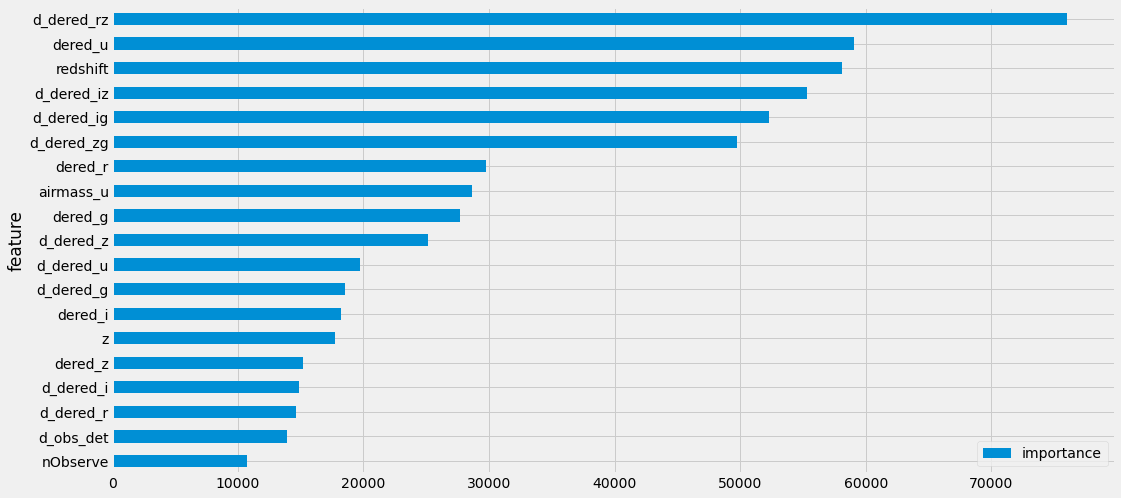

In [10]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성


In [8]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [9]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [10]:
sub[target_col].value_counts()

2    41059
0    29973
1     8968
Name: class, dtype: int64

In [11]:
sub.to_csv(sub_file)